# Plate Motion Calculator

 This notebook implements two approaches to calculate tectonic plate motion:

 - **Spherical Geometry Method**
 - **Vector Cross Product Method**

 The implementation follows the NUVEL-1A model for Euler poles and compares both methods visually and numerically.
 The class is fully reusable and can be tested with custom locations and Euler poles.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

class PlateMotionCalculator:
    """
    Class to compute plate motion using two methods: spherical geometry and vector cross-product.
    Allows storing Euler poles and observation points, calculating velocities, and plotting results.
    """
    R = 6371  # Earth's radius in km

    def __init__(self, method="spherical"):
        """Initialize the calculator with a default method."""
        self.locations = []
        self.euler_poles = {}
        self.method = method.lower()

    @staticmethod
    def deg2rad(deg):
        """Convert degrees to radians."""
        return deg * np.pi / 180

    @staticmethod
    def rad2deg(rad):
        """Convert radians to degrees."""
        return rad * 180 / np.pi

    def add_euler_pole(self, plate_pair, lat, lon, omega):
        """
        Add an Euler pole.
        
        Parameters:
        - plate_pair (str): Identifier for plate pair
        - lat, lon (float): Latitude and longitude of the pole (degrees)
        - omega (float): Angular velocity (deg/yr)
        """
        self.euler_poles[plate_pair] = {
            "lat": lat,
            "lon": lon,
            "omega": omega
        }

    def add_location(self, name, lat, lon, plate_pair):
        """
        Add an observation point.
        
        Parameters:
        - name (str): Identifier
        - lat, lon (float): Latitude and longitude
        - plate_pair (str): Associated Euler pole name
        """
        self.locations.append({
            "name": name,
            "lat": lat,
            "lon": lon,
            "plate_pair": plate_pair
        })

    def spherical_velocity(self, lat_p, lon_p, omega, lat_x, lon_x):
        """
        Calculate velocity using spherical geometry (Fowler equations).
        Returns velocity (m/yr), azimuth (deg), angle a (deg), and angle C (deg).
        """
        lambda_p, phi_p = self.deg2rad(lat_p), self.deg2rad(lon_p)
        lambda_x, phi_x = self.deg2rad(lat_x), self.deg2rad(lon_x)

        a = np.arccos(np.sin(lambda_x)*np.sin(lambda_p) + np.cos(lambda_x)*np.cos(lambda_p)*np.cos(phi_p - phi_x))
        C = np.arcsin((np.cos(lambda_p) * np.sin(phi_p - phi_x)) / np.sin(a))
        v = self.deg2rad(self.R * omega * np.sin(a)) * 1000  # m/yr
        beta = self.rad2deg(np.pi/2 + C)

        return v, beta % 360, self.rad2deg(a), self.rad2deg(C)

    def vector_velocity(self, lat_p, lon_p, omega, lat_x, lon_x):
        """
        Calculate velocity using vector cross-product.
        Returns velocity magnitude (m/yr), azimuth (deg), and vector components.
        """
        lambda_p, phi_p = self.deg2rad(lat_p), self.deg2rad(lon_p)
        lambda_x, phi_x = self.deg2rad(lat_x), self.deg2rad(lon_x)

        omega_vec = omega * np.array([
            np.cos(lambda_p) * np.cos(phi_p),
            np.cos(lambda_p) * np.sin(phi_p),
            np.sin(lambda_p)
        ])
        r_vec = self.R * np.array([
            np.cos(lambda_x) * np.cos(phi_x),
            np.cos(lambda_x) * np.sin(phi_x),
            np.sin(lambda_x)
        ])
        v_vec = np.cross(omega_vec, r_vec)
        v_mag = np.linalg.norm(v_vec) * 1000  # m/yr

        east = np.array([-np.sin(phi_x), np.cos(phi_x), 0])
        north = np.array([-np.sin(lambda_x)*np.cos(phi_x), -np.sin(lambda_x)*np.sin(phi_x), np.cos(lambda_x)])
        ve = np.dot(v_vec, east)
        vn = np.dot(v_vec, north)
        azimuth = (self.rad2deg(np.arctan2(ve, vn))) 
        
        if azimuth < 0: azimuth += 360
        if azimuth > 360: azimuth -= 360
        if azimuth > 180: azimuth = 360 - azimuth
        if azimuth < 180: azimuth = -azimuth + 360

        return self.deg2rad(v_mag), azimuth, v_vec 

    def calculate_all(self, methods=["spherical", "vector"], existing_df=None, overwrite=False):
        """
        Calculate velocity for all locations with given methods.

        Parameters:
        - methods (list): List of methods to compute ["spherical", "vector"]
        - existing_df (pd.DataFrame): Existing results to avoid duplication
        - overwrite (bool): Whether to replace existing rows

        Returns:
        - pd.DataFrame: Combined results for all locations
        """
        expected_columns = [
            "Location", "Plate Pair", "Method", "Euler Lat (°)", "Euler Lon (°)",
            "Omega (rad/yr)", "Point Lat (°)", "Point Lon (°)",
            "Velocity (cm/yr)", "Azimuth (°)",
            "Angle a (°)", "Angle C (°)", "Vector Components (cm/yr)"
        ]

        if existing_df is None or existing_df.empty:
            existing_df = pd.DataFrame(columns=expected_columns)
        else:
            existing_df = existing_df.dropna(axis=1, how='all')

        results = []

        for loc in self.locations:
            plate_pair = loc["plate_pair"]
            if plate_pair not in self.euler_poles:
                print(f"Warning: No Euler pole defined for '{plate_pair}'. Skipping '{loc['name']}'.")
                continue

            pole = self.euler_poles[plate_pair]

            for method in methods:
                mask = (
                    (existing_df["Location"] == loc["name"]) &
                    (existing_df["Plate Pair"] == plate_pair) &
                    (existing_df["Method"].str.lower() == method.lower())
                )

                if overwrite and mask.any():
                    existing_df = existing_df[~mask]

                if method == "spherical":
                    v, azimuth, a, C = self.spherical_velocity(
                        pole["lat"], pole["lon"], pole["omega"], loc["lat"], loc["lon"]
                    )
                    new_row = {
                        "Location": loc["name"],
                        "Plate Pair": plate_pair,
                        "Method": "Spherical",
                        "Euler Lat (°)": pole["lat"],
                        "Euler Lon (°)": pole["lon"],
                        "Omega (rad/yr)": pole["omega"],
                        "Point Lat (°)": loc["lat"],
                        "Point Lon (°)": loc["lon"],
                        "Velocity (cm/yr)": v * 100,
                        "Azimuth (°)": azimuth,
                        "Angle a (°)": a,
                        "Angle C (°)": C,
                        "Vector Components (cm/yr)": None
                    }
                elif method == "vector":
                    v, azimuth, v_components = self.vector_velocity(
                        pole["lat"], pole["lon"], pole["omega"], loc["lat"], loc["lon"]
                    )
                    new_row = {
                        "Location": loc["name"],
                        "Plate Pair": plate_pair,
                        "Method": "Vector",
                        "Euler Lat (°)": pole["lat"],
                        "Euler Lon (°)": pole["lon"],
                        "Omega (rad/yr)": pole["omega"],
                        "Point Lat (°)": loc["lat"],
                        "Point Lon (°)": loc["lon"],
                        "Velocity (cm/yr)": v * 100,
                        "Azimuth (°)": azimuth,
                        "Angle a (°)": None,
                        "Angle C (°)": None,
                        "Vector Components (cm/yr)": v_components.tolist()
                    }

                results.append(new_row)

        new_df = pd.DataFrame(results)

        if new_df.empty:
            return existing_df.copy()
        if existing_df.empty:
            return new_df.copy()

        new_df = new_df.reindex(columns=expected_columns)
        existing_df = existing_df.reindex(columns=expected_columns)
        return pd.concat([existing_df, new_df], ignore_index=True)


    def plot_velocities(self, dataframe, method_to_plot='vector'):
        """
        Plot velocity vectors and Euler poles on a global map.

        Parameters:
            dataframe (pd.DataFrame): Result table with velocities.
            method_to_plot (str): Choose between 'vector' and 'spherical'
        """
        method_to_plot = method_to_plot.lower()

        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
        ax.gridlines(draw_labels=True)

        labels = []
        plotted_poles = set()
        pole_labels = []

        for idx, loc in enumerate(self.locations, 1):
            row_match = dataframe[
                (dataframe["Location"] == loc["name"]) &
                (dataframe["Method"].str.lower() == method_to_plot)
            ]

            if row_match.empty:
                continue

            df_row = row_match.iloc[0]
            x = df_row["Point Lon (°)"]
            y = df_row["Point Lat (°)"]
            angle_rad = self.deg2rad(df_row["Azimuth (°)"])
            mag_scale = 10
            dy = mag_scale * np.cos(angle_rad)
            dx = mag_scale * np.sin(angle_rad)

            ax.arrow(x, y, dx, dy, head_width=5, head_length=5, fc='red', ec='red')
            ax.scatter(x, y, color='blue', s=50, zorder=5)
            ax.text(x + 0.3, y + 0.3, str(idx), fontsize=9, color='blue', fontweight='bold')
            labels.append(f"{idx}. {loc['name']}")

            plate_pair = loc["plate_pair"]
            if plate_pair not in plotted_poles:
                euler_row = dataframe[
                    (dataframe["Plate Pair"] == plate_pair) &
                    (dataframe["Method"].str.lower() == method_to_plot)
                ]
                if not euler_row.empty:
                    euler_row = euler_row.iloc[0]
                    x_euler = euler_row["Euler Lon (°)"]
                    y_euler = euler_row["Euler Lat (°)"]
                    ax.scatter(x_euler, y_euler, color='green', s=50, zorder=5)
                    ax.text(x_euler + 0.3, y_euler + 0.3, f"P{len(plotted_poles)+1}", fontsize=8, color='green', fontweight='bold')
                    pole_labels.append(f"P{len(plotted_poles)+1}. {plate_pair}: ({y_euler:.1f}, {x_euler:.1f})")
                    plotted_poles.add(plate_pair)

        plt.title(f"Plate Velocities ({method_to_plot.capitalize()} Method)")
        legend_text = "\n".join(labels)
        pole_text = "\n".join(pole_labels)
        plt.gcf().text(0.85, 0.5, "LOCATIONS\n" + legend_text, fontsize=9, fontweight='semibold',
                       va='center', ha='left',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))
        plt.gcf().text(0.85, 0.2, "EULER POINTS\n" + pole_text, fontsize=8,
                       va='top', ha='left',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="#f0f0f0", edgecolor="gray"))
        plt.subplots_adjust(right=0.8)
        plt.show()

# Testing the Plate Motion Calculator

 In this section, we test the full functionality of the `PlateMotionCalculator` using example data from NUVEL-1A.

 We include:
 - Adding Euler poles and tectonic observation points
 - Computing velocities with both **spherical** and **vector** methods
 - Plotting the results including:
     - Velocity vectors (with arrow direction and magnitude)
     - Locations numbered on the map
     - Euler poles labeled as `P1`, `P2`, etc.

 Finally, results are exported for further analysis.

In [46]:
# Create the calculator instance
pm = PlateMotionCalculator()

In [47]:
# Add Euler poles from NUVEL-1A (lat, lon in degrees, omega in deg/year converted to rad/year)
pm.add_euler_pole("Africa–Antarctica", 5.6, -39.2, 1.3e-7)
pm.add_euler_pole("Africa–North America", 78.8, 38.5, 2.4e-7)
pm.add_euler_pole("South America–Antarctica", -86.4, 139.3, 2.6e-7)
pm.add_euler_pole("India–Eurasia", 24.4, 17.5, 5.0e-7)
pm.add_euler_pole("North America–Pacific", 48.7, -78.2, 7.5e-7)
pm.add_euler_pole("Nazca–South America", 56.0, -94.0, 7.2e-7)

In [48]:
# Add tectonic observation points
pm.add_location("San Andreas Fault", 38.0, -122.0, "North America–Pacific")
pm.add_location("Southwest Indian Ridge", -55.0, 5.0, "Africa–Antarctica")
pm.add_location("Mid-Atlantic Ridge (52°S)", -52.0, 5.0, "South America–Antarctica")
pm.add_location("Mid-Atlantic Ridge (9°N)", 9.0, -40.0, "Africa–North America")
pm.add_location("Mid-Atlantic Ridge (35°N)", 35.0, -35.0, "Africa–North America")
pm.add_location("Himalayas", 35.0, 72.0, "India–Eurasia")
pm.add_location("S. Chile Trench", -35.0, -74.0, "Nazca–South America")
pm.add_location("N. Peru Trench", -4.0, -82.0, "Nazca–South America")

### Compute velocities

 We now compute the motion of the tectonic points using both methods.

In [49]:
df = pm.calculate_all(methods=["spherical", "vector"], overwrite=True)

# Export results to CSV
df.to_csv("plate_velocities.csv", index=False)

# Display preview
df

,Location,Plate Pair,Method,Euler Lat (°),Euler Lon (°),Omega (rad/yr),Point Lat (°),Point Lon (°),Velocity (cm/yr),Azimuth (°),Angle a (°),Angle C (°),Vector Components (cm/yr)
0,San Andreas Fault,North America–Pacific,Spherical,48.7,-78.2,7.500000e-07,38.0,-122.0,4.551918,146.818085,33.080606,56.818085,None
1,San Andreas Fault,North America–Pacific,Vector,48.7,-78.2,7.500000e-07,38.0,-122.0,4.551918,213.181915,NaN,NaN,"[0.0004983591577526986, -0.00189605200030809, ..."
2,Southwest Indian Ridge,Africa–Antarctica,Spherical,5.6,-39.2,1.300000e-07,-55.0,5.0,1.364907,42.707679,70.773385,-47.292321,None
3,Southwest Indian Ridge,Africa–Antarctica,Vector,5.6,-39.2,1.300000e-07,-55.0,5.0,1.364907,317.292321,NaN,NaN,"[0.0004227111744722368, 0.0005694296528606134,..."
4,Mid-Atlantic Ridge (52°S),South America–Antarctica,Spherical,-86.4,139.3,2.600000e-07,-52.0,5.0,1.880807,93.960986,40.583678,3.960986,None
5,Mid-Atlantic Ridge (52°S),South America–Antarctica,Vector,-86.4,139.3,2.600000e-07,-52.0,5.0,1.880807,266.039014,NaN,NaN,"[3.526102975059419e-05, -0.0010760706059764328..."
6,Mid-Atlantic Ridge (9°N),Africa–North America,Spherical,78.8,38.5,2.400000e-07,9.0,-40.0,2.619182,101.182334,78.947841,11.182334,None
7,Mid-Atlantic Ridge (9°N),Africa–North America,Vector,78.8,38.5,2.400000e-07,9.0,-40.0,2.619182,258.817666,NaN,NaN,"[0.0009811816473530928, 0.0010984991513533632,..."
8,Mid-Atlantic Ridge (35°N),Africa–North America,Spherical,78.8,38.5,2.400000e-07,35.0,-35.0,2.119086,103.564310,52.566391,13.564310,None
9,Mid-Atlantic Ridge (35°N),Africa–North America,Vector,78.8,38.5,2.400000e-07,35.0,-35.0,2.119086,256.435690,NaN,NaN,"[0.0008107756385685432, 0.000873145732853989, ..."


### Plot Results

 The following plots display:
 - Red arrows representing direction and magnitude of motion.
 - Blue dots and numbers for location IDs.
 - Green dots with labels for Euler poles.

 Each method can be visualized separately for comparison.

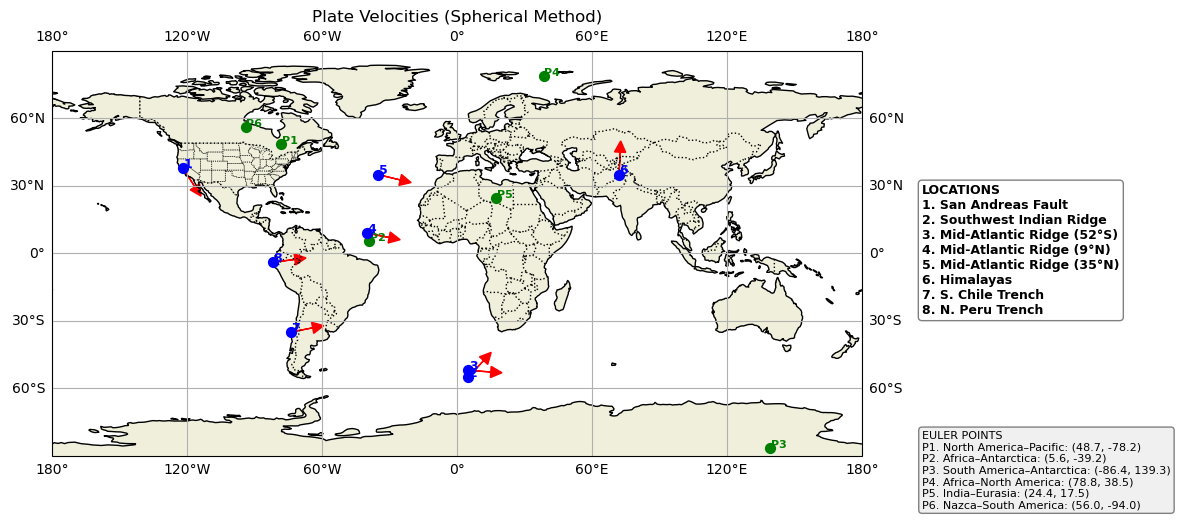

In [50]:
# Plot with spherical method
pm.plot_velocities(df, method_to_plot="spherical")

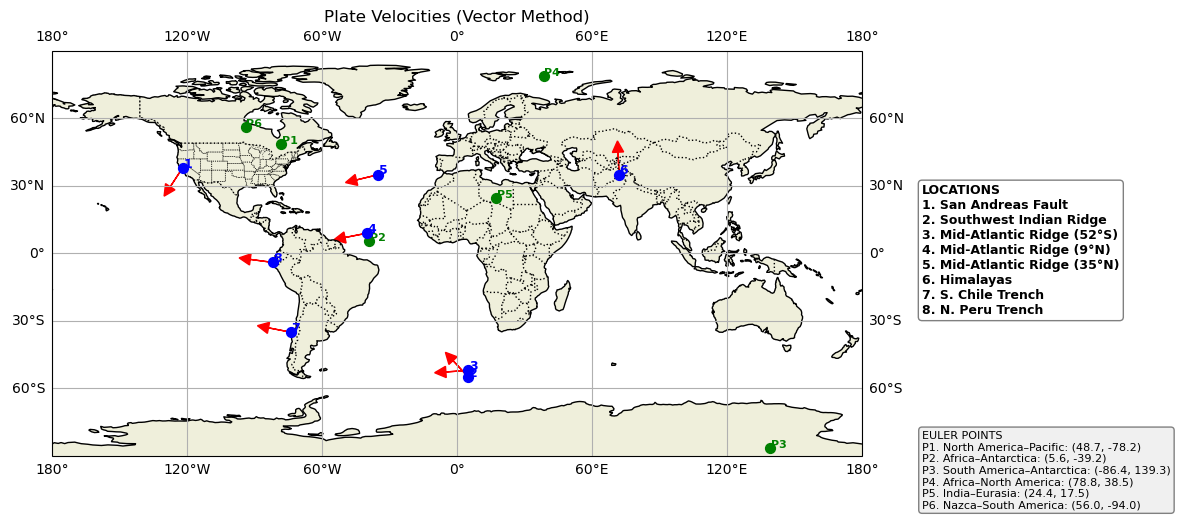

In [51]:
# Plot with vector method
pm.plot_velocities(df, method_to_plot="vector")